# Text Similarity Tutorial: From Basic to Advanced Techniques

In this notebook, we'll explore different text similarity techniques using documents from the SAT case study dataset. We'll progressively build from simple methods to advanced deep learning approaches.

**Learning Objectives:**
1. Understand bag-of-words representation and Jaccard similarity
2. Improve similarity with stop word removal and stemming
3. Apply cosine similarity for better comparison
4. Use TF-IDF to weight terms by importance
5. Train and use BERT models for semantic similarity

**Dataset:** Network congestion control algorithm descriptions (BBR, CUBIC, Hybla, NewReno, and comparative studies)

## Setup: Import Libraries and Load Data

In [35]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import re
from collections import Counter
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)

In [30]:
# Load documents from the dataset
dataset_path = Path('datasets/sat_case_study')

documents = {}
for file_path in dataset_path.glob('*.txt'):
    with open(file_path, 'r', encoding='utf-8') as f:
        documents[file_path.stem] = f.read()

print(f"Loaded {len(documents)} documents:")
for name in documents.keys():
    print(f"  - {name}")



Loaded 5 documents:
  - CUBIC
  - NewReno
  - comp_study
  - Hybla
  - BBR


## Define Questions

Edit this cell to define your questions. We'll find which document best matches each question.

In [75]:
# Define your questions here
# These questions have clear answers in specific documents!
questions = [
    "What is BBR and how does it use control and estimation theory?",  # Answer in BBR.txt
    "What states does BBR use to handle connection startup and shutdown?",  # Answer in BBR.txt
    "How does CUBIC modify TCP to improve scalability on fast and long distance networks?",  # Answer in CUBIC.txt
    "What is the default TCP algorithm in Linux?",  # Answer in CUBIC.txt
    "How does TCP Hybla handle the effects of long round trip times?",  # Answer in Hybla.txt
    "Which congestion control scheme achieves high throughput but suffers from large latency?",  # Answer in comp_study.txt
    "What tradeoff does BBR make compared to other algorithms?",  # Answer in comp_study.txt
    "How does CUBIC achieve fair bandwidth allocation among flows with different RTTs?",  # Answer in CUBIC.txt
    # Harder questions that require semantic understanding.
    "Which algorithm sidesteps the impossibility of measuring network parameters simultaneously by using sequential estimation?",  # Answer in BBR.txt - requires understanding "sidestep impossibility" relates to BBR
    "What method doubles transmission speed during initialization to discover bandwidth capacity?",  # Answer in BBR.txt - requires understanding "doubles" = "gain of 2/ln2" and "initialization" = "Startup"
    "Which protocol compensates for communication delays in satellite links?",  # Answer in Hybla.txt - requires understanding "satellite links" = "long RTT"
    "What approach prioritizes minimal queue depth over maximum data transfer rate?",  # Answer in comp_study.txt - requires understanding "minimal queue" = "delay-based" like Vegas
]

In [76]:
# Map each question to its correct answer document
correct_documents = [
    'BBR',           # Q1: What is BBR...
    'BBR',           # Q2: What states does BBR...
    'CUBIC',         # Q3: How does CUBIC modify...
    'CUBIC',         # Q4: What is the default TCP...
    'Hybla',         # Q5: How does TCP Hybla...
    'comp_study',    # Q6: Which congestion control...
    'comp_study',    # Q7: What tradeoff does BBR...
    'CUBIC',         # Q8: How does CUBIC achieve...
    'BBR',           # Q9: Which algorithm sidesteps impossibility... (harder - semantic)
    'BBR',           # Q10: What method doubles transmission... (harder - semantic)
    'Hybla',         # Q11: Which protocol compensates for satellite... (harder - semantic)
    'comp_study'     # Q12: What approach prioritizes minimal queue... (harder - semantic)
]

---
## Method 1: Bag of Words with Jaccard Similarity

**Concept:** Represent text as a set of words and compute similarity using the Jaccard index:

$$J(A, B) = \frac{|A \cap B|}{|A \cup B|}$$

This measures the overlap between two sets of words.

In [77]:
def tokenize_simple(text):
    """Convert text to lowercase and split into words"""
    return set(re.findall(r'\b\w+\b', text.lower()))

def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets"""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0.0

In [78]:
def plot_similarity_heatmap(results, questions, documents, title="Similarity Heatmap"):
    """
    Create a heatmap visualization for similarity scores.
    
    Parameters:
    -----------
    results : list
        List of result dictionaries containing 'all_scores' and 'correct_doc' keys
    questions : list
        List of question strings
    documents : dict
        Dictionary of document names and content
    title : str
        Title for the heatmap
    """
    # Build heatmap data
    heatmap_data = []
    for q_idx, r in enumerate(results):
        row = []
        for doc_name in documents.keys():
            row.append(r['all_scores'][doc_name])
        heatmap_data.append(row)
    
    # Create dataframe with question labels
    df = pd.DataFrame(heatmap_data,
                      index=[f"Q{i+1}: {questions[i]}" for i in range(len(questions))],
                      columns=list(documents.keys()))
    
    # Wrap long question labels
    new_labels = []
    for label in df.index:
        if len(label) > 50:
            q_part, q_text = label.split(":", 1)
            wrapped_text = '\n'.join(re.findall('.{1,50}(?:\s+|$)', q_text.strip()))
            new_label = f"{q_part}: {wrapped_text}"
            new_labels.append(new_label)
        else:
            new_labels.append(label)
    df.index = new_labels
    
    # Create plot
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=False, fmt=".2f", cmap="YlGnBu")
    
    # Custom annotation: bold and red for correct answers
    ax = plt.gca()
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            value = df.iat[i, j]
            is_correct = (results[i]['correct_doc'] == df.columns[j])
            if is_correct:
                ax.text(j + 0.5, i + 0.5, f"{value:.2f}", 
                       ha='center', va='center', fontsize=10, 
                       fontweight='bold', color='red')
            else:
                ax.text(j + 0.5, i + 0.5, f"{value:.2f}", 
                       ha='center', va='center', fontsize=10)
    
    plt.title(title)
    plt.xlabel("Documents")
    plt.ylabel("Questions")
    plt.tight_layout()
    plt.show()



📊 Jaccard Similarity Heatmap:


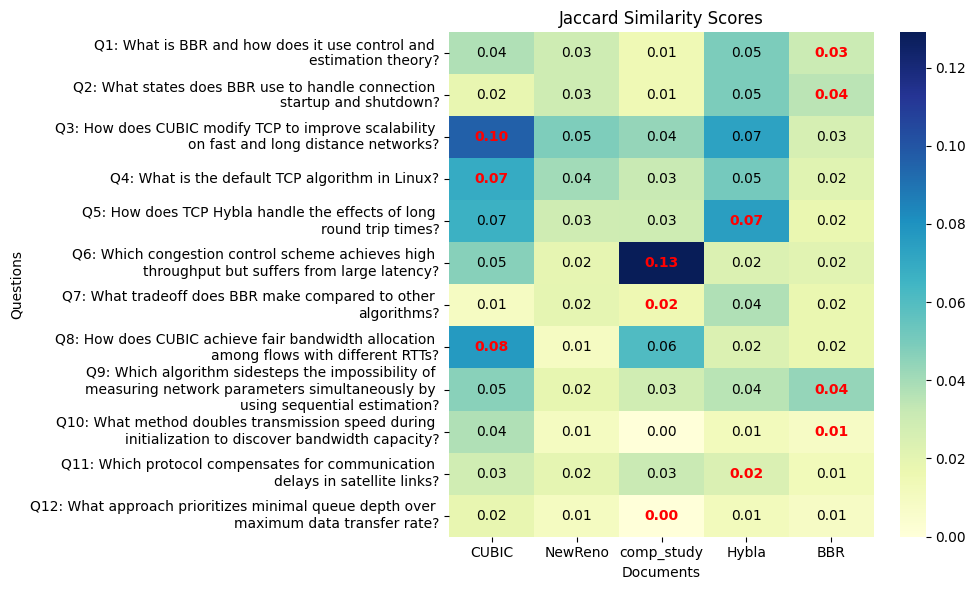

In [79]:
# Compute Jaccard similarity for each question
results_jaccard = []

for q_idx, question in enumerate(questions):
    q_tokens = tokenize_simple(question)
    scores = {}
    
    for doc_name, doc_text in documents.items():
        doc_tokens = tokenize_simple(doc_text)
        scores[doc_name] = jaccard_similarity(q_tokens, doc_tokens)
    
    # Sort by score descending
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    best_match, best_score = sorted_scores[0]
    
    # Find rank and score of correct answer
    correct_doc = correct_documents[q_idx]
    correct_rank = next(i+1 for i, (doc, _) in enumerate(sorted_scores) if doc == correct_doc)
    correct_score = scores[correct_doc]
    
    results_jaccard.append({
        'question': question[:50] + '...',
        'correct_doc': correct_doc,
        'top_retrieved': best_match,
        'top_score': best_score,
        'correct_rank': correct_rank,
        'correct_score': correct_score,
        'is_correct': best_match == correct_doc,
        'all_scores': scores
    })

# Plot heatmap
print("\n📊 Jaccard Similarity Heatmap:")
print("="*100)
plot_similarity_heatmap(results_jaccard, questions, documents, 
                        title="Jaccard Similarity Scores")



**Observations:**
- Jaccard similarity is simple but treats all words equally
- Common words like "the", "is", "and" affect the score
- No consideration of word frequency

Let's improve this!

---
## Method 2: Stop Word Removal and Stemming

**Improvements:**
- Remove common words (stop words) that don't carry much meaning
- Reduce words to their root form (stemming) to match variations

In [80]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


In [81]:
# Initialize stop words and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def tokenize_enhanced(text):
    """Tokenize with stop word removal and stemming"""
    words = re.findall(r'\b\w+\b', text.lower())
    # Remove stop words and apply stemming
    filtered_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return set(filtered_words)

# Example comparison
sample_text = "The algorithms are running efficiently and performing well"
print("Original tokens:", tokenize_simple(sample_text))
print("Enhanced tokens:", tokenize_enhanced(sample_text))

Original tokens: {'performing', 'the', 'running', 'algorithms', 'and', 'well', 'are', 'efficiently'}
Enhanced tokens: {'perform', 'effici', 'run', 'well', 'algorithm'}



📊 Enhanced Jaccard (Stop Words + Stemming) Heatmap:


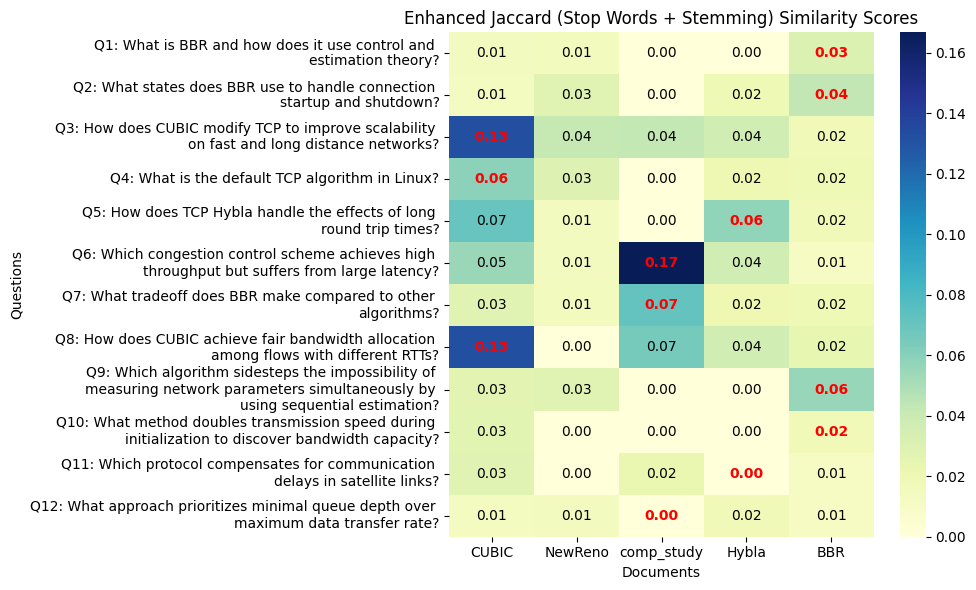

In [82]:
# Compute Jaccard similarity with enhanced tokenization
results_enhanced = []

for q_idx, question in enumerate(questions):
    q_tokens = tokenize_enhanced(question)
    scores = {}
    
    for doc_name, doc_text in documents.items():
        doc_tokens = tokenize_enhanced(doc_text)
        scores[doc_name] = jaccard_similarity(q_tokens, doc_tokens)
    
    # Sort by score descending
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    best_match, best_score = sorted_scores[0]
    
    # Find rank and score of correct answer
    correct_doc = correct_documents[q_idx]
    correct_rank = next(i+1 for i, (doc, _) in enumerate(sorted_scores) if doc == correct_doc)
    correct_score = scores[correct_doc]
    
    results_enhanced.append({
        'question': question[:50] + '...',
        'correct_doc': correct_doc,
        'top_retrieved': best_match,
        'top_score': best_score,
        'correct_rank': correct_rank,
        'correct_score': correct_score,
        'is_correct': best_match == correct_doc,
        'all_scores': scores
    })

# Plot heatmap
print("\n📊 Enhanced Jaccard (Stop Words + Stemming) Heatmap:")
print("="*100)
plot_similarity_heatmap(results_enhanced, questions, documents,
                        title="Enhanced Jaccard (Stop Words + Stemming) Similarity Scores")


---
## Method 3: Cosine Similarity with Count Vectors

**Concept:** Instead of treating text as sets, use vectors where each dimension represents a word and the value is its frequency.

Cosine similarity measures the angle between vectors:

$$\text{cosine}(A, B) = \frac{A \cdot B}{\|A\| \|B\|} = \frac{\sum_{i} A_i B_i}{\sqrt{\sum_{i} A_i^2} \sqrt{\sum_{i} B_i^2}}$$

This considers word frequency and is bounded between 0 and 1 for positive counts.

In [83]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Preprocessing function for vectorizer
def preprocess_text(text):
    """Preprocess text for vectorization"""
    words = re.findall(r'\b\w+\b', text.lower())
    filtered_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Create count vectorizer
vectorizer = CountVectorizer()

# Preprocess all documents
doc_names = list(documents.keys())
doc_texts = [preprocess_text(documents[name]) for name in doc_names]

# Fit vectorizer on documents
doc_vectors = vectorizer.fit_transform(doc_texts)

print(f"Vocabulary size: {len(vectorizer.vocabulary_)} unique stemmed words")
print(f"Document vectors shape: {doc_vectors.shape}")

Vocabulary size: 295 unique stemmed words
Document vectors shape: (5, 295)



📊 Cosine Similarity Heatmap:


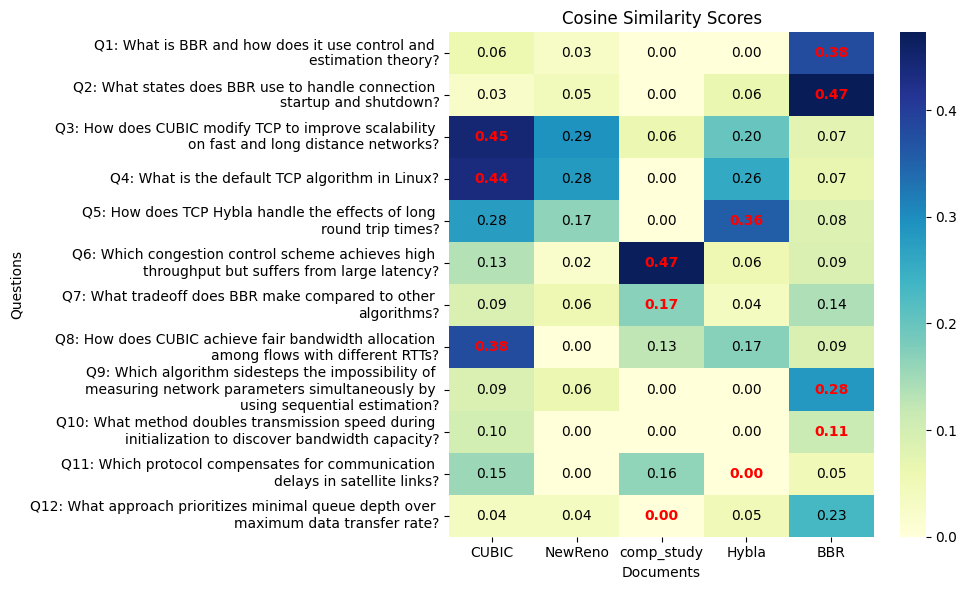

In [84]:
# Compute cosine similarity
results_cosine = []

# Create document corpus
corpus = [documents[doc] for doc in sorted(documents.keys())]
doc_names = sorted(documents.keys())

# Vectorize documents
vectorizer = CountVectorizer(preprocessor=preprocess_text, lowercase=True)
doc_vectors = vectorizer.fit_transform(corpus)

for q_idx, question in enumerate(questions):
    # Vectorize question using same vocabulary
    q_vector = vectorizer.transform([question])
    
    # Compute cosine similarity
    similarities = cosine_similarity(q_vector, doc_vectors)[0]
    scores = dict(zip(doc_names, similarities))
    
    # Sort by score descending
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    best_match, best_score = sorted_scores[0]
    
    # Find rank and score of correct answer
    correct_doc = correct_documents[q_idx]
    correct_rank = next(i+1 for i, (doc, _) in enumerate(sorted_scores) if doc == correct_doc)
    correct_score = scores[correct_doc]
    
    results_cosine.append({
        'question': question[:50] + '...',
        'correct_doc': correct_doc,
        'top_retrieved': best_match,
        'top_score': best_score,
        'correct_rank': correct_rank,
        'correct_score': correct_score,
        'is_correct': best_match == correct_doc,
        'all_scores': scores
    })

# Plot heatmap
print("\n📊 Cosine Similarity Heatmap:")
print("="*100)
plot_similarity_heatmap(results_cosine, questions, documents,
                        title="Cosine Similarity Scores")


---
## Method 4: TF-IDF (Term Frequency-Inverse Document Frequency)

**Concept:** Weight words by their importance across the corpus.

- **TF (Term Frequency):** How often a word appears in a document
- **IDF (Inverse Document Frequency):** How rare a word is across all documents

$$\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \log\frac{N}{\text{DF}(t)}$$

where $N$ is the number of documents and $\text{DF}(t)$ is the number of documents containing term $t$.

Common words get lower weights, rare words get higher weights.

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform documents
tfidf_vectors = tfidf_vectorizer.fit_transform(doc_texts)

print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)} unique words")
print(f"TF-IDF vectors shape: {tfidf_vectors.shape}")

TF-IDF vocabulary size: 295 unique words
TF-IDF vectors shape: (5, 295)


In [86]:
# Examine top TF-IDF terms for each document
feature_names = tfidf_vectorizer.get_feature_names_out()

print("Top 5 TF-IDF terms per document:")
print("="*80)
for i, doc_name in enumerate(doc_names):
    tfidf_scores = tfidf_vectors[i].toarray()[0]
    top_indices = tfidf_scores.argsort()[-5:][::-1]
    top_terms = [(feature_names[idx], tfidf_scores[idx]) for idx in top_indices]
    print(f"\n{doc_name}:")
    for term, score in top_terms:
        print(f"  {term}: {score:.3f}")

Top 5 TF-IDF terms per document:

BBR:
  window: 0.337
  tcp: 0.282
  cubic: 0.279
  protocol: 0.250
  flow: 0.202

CUBIC:
  fast: 0.365
  newreno: 0.305
  tcp: 0.298
  recoveri: 0.244
  modif: 0.226

Hybla:
  throughput: 0.612
  good: 0.306
  delay: 0.205
  suffer: 0.204
  four: 0.204

NewReno:
  hybla: 0.437
  tcp: 0.369
  rtt: 0.366
  perform: 0.219
  eﬀect: 0.218

comp_study:
  queue: 0.290
  use: 0.273
  startup: 0.242
  bbr: 0.242
  btlbw: 0.193



📊 TF-IDF Similarity Heatmap:


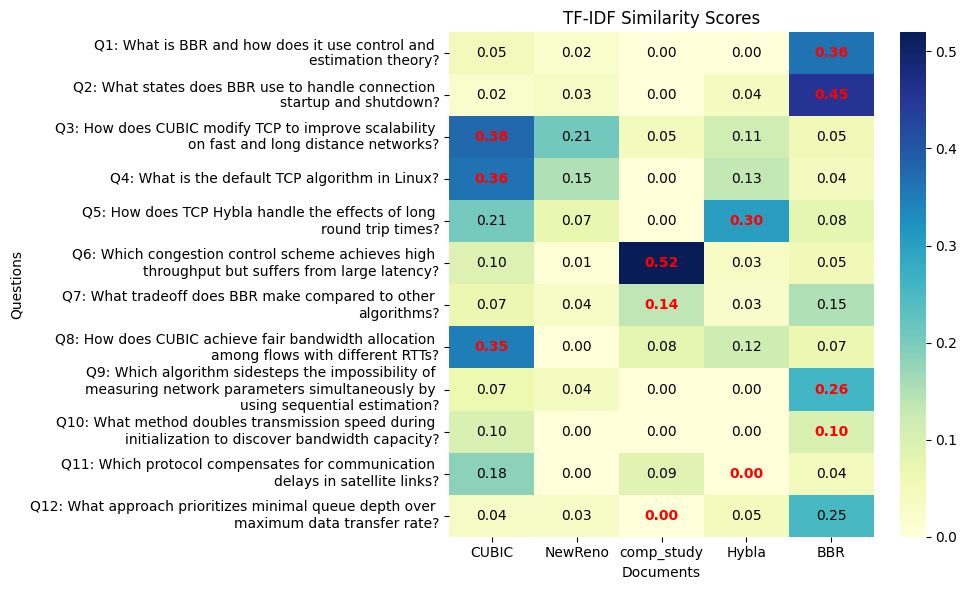

In [87]:
# Compute TF-IDF similarity
results_tfidf = []

# Create document corpus
corpus = [documents[doc] for doc in sorted(documents.keys())]
doc_names = sorted(documents.keys())

# Vectorize documents with TF-IDF
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocess_text, lowercase=True)
doc_vectors = tfidf_vectorizer.fit_transform(corpus)

for q_idx, question in enumerate(questions):
    # Vectorize question using same vocabulary
    q_vector = tfidf_vectorizer.transform([question])
    
    # Compute cosine similarity
    similarities = cosine_similarity(q_vector, doc_vectors)[0]
    scores = dict(zip(doc_names, similarities))
    
    # Sort by score descending
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    best_match, best_score = sorted_scores[0]
    
    # Find rank and score of correct answer
    correct_doc = correct_documents[q_idx]
    correct_rank = next(i+1 for i, (doc, _) in enumerate(sorted_scores) if doc == correct_doc)
    correct_score = scores[correct_doc]
    
    results_tfidf.append({
        'question': question[:50] + '...',
        'correct_doc': correct_doc,
        'top_retrieved': best_match,
        'top_score': best_score,
        'correct_rank': correct_rank,
        'correct_score': correct_score,
        'is_correct': best_match == correct_doc,
        'all_scores': scores
    })

# Plot heatmap
print("\n📊 TF-IDF Similarity Heatmap:")
print("="*100)
plot_similarity_heatmap(results_tfidf, questions, documents,
                        title="TF-IDF Similarity Scores")


In [88]:
# Create comprehensive accuracy comparison
print("\n📈 Method Accuracy Summary:")
print("="*100)
accuracy_data = []
methods_data = [
    ('Jaccard', results_jaccard),
    ('Enhanced', results_enhanced),
    ('Cosine', results_cosine),
    ('TF-IDF', results_tfidf)
]

for method_name, results in methods_data:
    correct_count = sum(1 for r in results if r['is_correct'])
    total_count = len(results)
    accuracy_pct = (correct_count / total_count) * 100
    accuracy_data.append({
        'Method': method_name,
        'Correct': f"{correct_count}/{total_count}",
        'Accuracy': f"{accuracy_pct:.1f}%"
    })

accuracy_df = pd.DataFrame(accuracy_data)
display(accuracy_df)

# Show detailed ranking for each method
print("\n📊 Detailed Ranking Comparison (Rank of Correct Answer):")
print("="*100)
ranking_data = []
for q_idx in range(len(questions)):
    ranking_data.append({
        'Q#': q_idx + 1,
        'Jaccard Rank': f"#{results_jaccard[q_idx]['correct_rank']}",
        'Enhanced Rank': f"#{results_enhanced[q_idx]['correct_rank']}",
        'Cosine Rank': f"#{results_cosine[q_idx]['correct_rank']}",
        'TF-IDF Rank': f"#{results_tfidf[q_idx]['correct_rank']}"
    })
ranking_df = pd.DataFrame(ranking_data)
display(ranking_df)


📈 Method Accuracy Summary:


,Method,Correct,Accuracy
0,Jaccard,5/12,41.7%
1,Enhanced,8/12,66.7%
2,Cosine,10/12,83.3%
3,TF-IDF,8/12,66.7%



📊 Detailed Ranking Comparison (Rank of Correct Answer):


,Q#,Jaccard Rank,Enhanced Rank,Cosine Rank,TF-IDF Rank
0,1,#3,#1,#1,#1
1,2,#2,#1,#1,#1
2,3,#1,#1,#1,#1
3,4,#1,#1,#1,#1
4,5,#1,#2,#1,#1
5,6,#1,#1,#1,#1
6,7,#4,#1,#1,#2
7,8,#1,#1,#1,#1
8,9,#2,#1,#1,#1
9,10,#4,#2,#1,#2


---
## Method 5: BERT - Semantic Similarity with Deep Learning

**Concept:** Use pre-trained transformer models to capture semantic meaning, not just word overlap.

BERT (Bidirectional Encoder Representations from Transformers) creates context-aware embeddings where similar meanings have similar vector representations, even with different words.

We'll use `sentence-transformers` which provides BERT models fine-tuned for semantic similarity.

In [89]:
from sentence_transformers import SentenceTransformer

In [90]:
# Load pre-trained BERT model for semantic similarity
# Using 'all-MiniLM-L6-v2' - a good balance of speed and quality
print("Loading BERT model...")
bert_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
print("✓ Model loaded successfully")

# The model outputs 384-dimensional embeddings
print(f"Embedding dimension: {bert_model.get_sentence_embedding_dimension()}")

Loading BERT model...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ Model loaded successfully
Embedding dimension: 768


In [91]:
# Generate embeddings for all documents (using original text, not preprocessed)
print("Encoding documents...")
doc_embeddings = bert_model.encode([documents[name] for name in doc_names], 
                                    show_progress_bar=False,
                                    convert_to_numpy=True)

print(f"\nDocument embeddings shape: {doc_embeddings.shape}")
print(f"Each document is represented as a {doc_embeddings.shape[1]}-dimensional vector")

Encoding documents...

Document embeddings shape: (5, 768)
Each document is represented as a 768-dimensional vector


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



📊 BERT Semantic Similarity Heatmap:


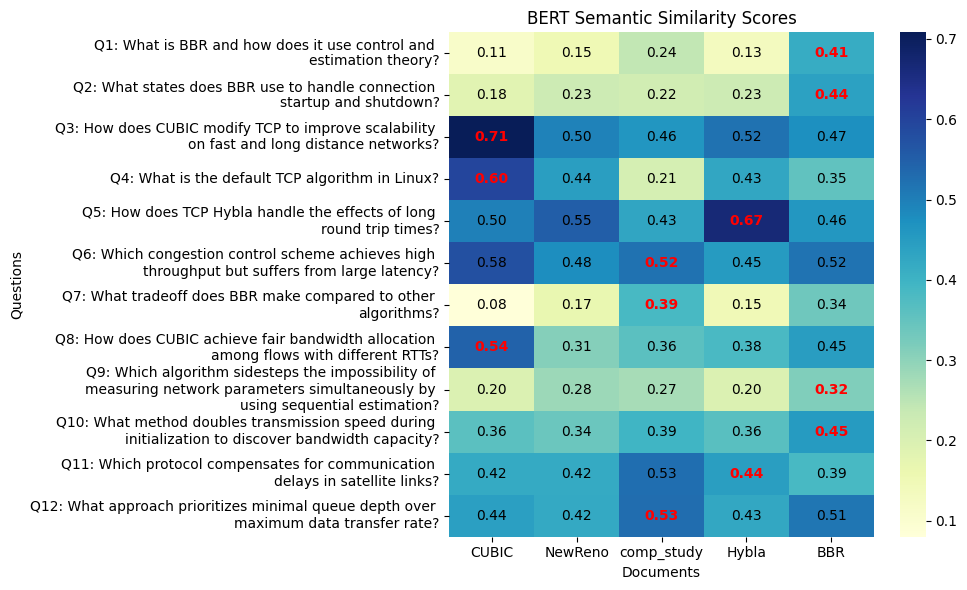

In [92]:
# Compute BERT semantic similarity
results_bert = []

# Load BERT model
model = SentenceTransformer('all-mpnet-base-v2')

# Encode documents
doc_names = sorted(documents.keys())
doc_texts = [documents[doc] for doc in doc_names]
doc_embeddings = model.encode(doc_texts)

for q_idx, question in enumerate(questions):
    # Encode question
    q_embedding = model.encode([question])
    
    # Compute cosine similarity
    similarities = cosine_similarity(q_embedding, doc_embeddings)[0]
    scores = dict(zip(doc_names, similarities))
    
    # Sort by score descending
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    best_match, best_score = sorted_scores[0]
    
    # Find rank and score of correct answer
    correct_doc = correct_documents[q_idx]
    correct_rank = next(i+1 for i, (doc, _) in enumerate(sorted_scores) if doc == correct_doc)
    correct_score = scores[correct_doc]
    
    results_bert.append({
        'question': question[:50] + '...',
        'correct_doc': correct_doc,
        'top_retrieved': best_match,
        'top_score': best_score,
        'correct_rank': correct_rank,
        'correct_score': correct_score,
        'is_correct': best_match == correct_doc,
        'all_scores': scores
    })

# Plot heatmap
print("\n📊 BERT Semantic Similarity Heatmap:")
print("="*100)
plot_similarity_heatmap(results_bert, questions, documents,
                        title="BERT Semantic Similarity Scores")


In [93]:
# Detailed view: Show similarity scores for all documents per question
print("\n📊 Detailed BERT Similarity Scores:")
print("="*100)

for i, r in enumerate(results_bert):
    print(f"\nQ{i+1}: {r['question']}")
    print("-" * 100)
    sorted_scores = sorted(r['all_scores'].items(), key=lambda x: x[1], reverse=True)
    for doc, score in sorted_scores:
        bar = '█' * int(score * 50)
        marker = " ← Correct Answer" if doc == r['correct_doc'] else ""
        print(f"  {doc:15s} {score:.4f} {bar}{marker}")


📊 Detailed BERT Similarity Scores:

Q1: What is BBR and how does it use control and estima...
----------------------------------------------------------------------------------------------------
  BBR             0.4141 ████████████████████ ← Correct Answer
  comp_study      0.2436 ████████████
  NewReno         0.1538 ███████
  Hybla           0.1341 ██████
  CUBIC           0.1127 █████

Q2: What states does BBR use to handle connection star...
----------------------------------------------------------------------------------------------------
  BBR             0.4389 █████████████████████ ← Correct Answer
  NewReno         0.2255 ███████████
  Hybla           0.2254 ███████████
  comp_study      0.2170 ██████████
  CUBIC           0.1847 █████████

Q3: How does CUBIC modify TCP to improve scalability o...
----------------------------------------------------------------------------------------------------
  CUBIC           0.7081 ███████████████████████████████████ ← Correct Answer


---
## Final Comparison: All Methods

Let's compare all five methods side-by-side by accuracy and ranking.

In [94]:
# Final accuracy summary across all methods
print("\n" + "="*100)
print("📊 FINAL ACCURACY COMPARISON: All Methods")
print("="*100)

all_results = [
    ('Jaccard', results_jaccard),
    ('Enhanced', results_enhanced),
    ('Cosine', results_cosine),
    ('TF-IDF', results_tfidf),
    ('BERT', results_bert)
]

final_accuracy = []
for method_name, results in all_results:
    correct_count = sum(1 for r in results if r['is_correct'])
    total_count = len(results)
    accuracy_pct = (correct_count / total_count) * 100
    avg_rank = np.mean([r['correct_rank'] for r in results])
    final_accuracy.append({
        'Method': method_name,
        'Correct': f"{correct_count}/{total_count}",
        'Accuracy': f"{accuracy_pct:.1f}%",
        'Avg Rank of Correct Answer': f"{avg_rank:.2f}"
    })

final_accuracy_df = pd.DataFrame(final_accuracy)
display(final_accuracy_df)


📊 FINAL ACCURACY COMPARISON: All Methods


,Method,Correct,Accuracy,Avg Rank of Correct Answer
0,Jaccard,5/12,41.7%,2.33
1,Enhanced,8/12,66.7%,1.83
2,Cosine,10/12,83.3%,1.58
3,TF-IDF,8/12,66.7%,1.75
4,BERT,10/12,83.3%,1.17


In [95]:
# Detailed ranking table for all questions and methods
print("\n📊 Complete Ranking Analysis:")
print("="*100)
detailed_ranking = []
for q_idx in range(len(questions)):
    row = {
        'Q#': q_idx + 1,
        'Correct Doc': correct_documents[q_idx]
    }
    for method_name, results in all_results:
        r = results[q_idx]
        row[f'{method_name} Rank'] = f"#{r['correct_rank']}"
    detailed_ranking.append(row)

detailed_df = pd.DataFrame(detailed_ranking)
display(detailed_df)


📊 Complete Ranking Analysis:


,Q#,Correct Doc,Jaccard Rank,Enhanced Rank,Cosine Rank,TF-IDF Rank,BERT Rank
0,1,BBR,#3,#1,#1,#1,#1
1,2,BBR,#2,#1,#1,#1,#1
2,3,CUBIC,#1,#1,#1,#1,#1
3,4,CUBIC,#1,#1,#1,#1,#1
4,5,Hybla,#1,#2,#1,#1,#1
5,6,comp_study,#1,#1,#1,#1,#2
6,7,comp_study,#4,#1,#1,#2,#1
7,8,CUBIC,#1,#1,#1,#1,#1
8,9,BBR,#2,#1,#1,#1,#1
9,10,BBR,#4,#2,#1,#2,#1


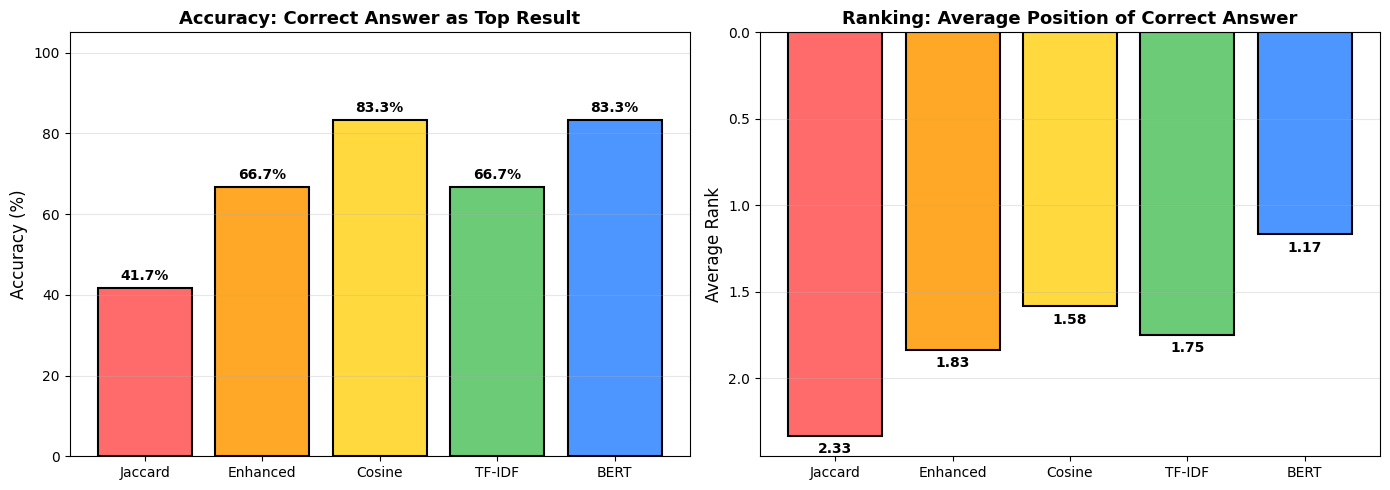

In [96]:
# Visualize accuracy comparison
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy comparison
methods_list = ['Jaccard', 'Enhanced', 'Cosine', 'TF-IDF', 'BERT']
accuracies = []
for method_name, results in all_results:
    correct_count = sum(1 for r in results if r['is_correct'])
    total_count = len(results)
    accuracy_pct = (correct_count / total_count) * 100
    accuracies.append(accuracy_pct)

colors = ['#FF6B6B', '#FFA726', '#FFD93D', '#6BCB77', '#4D96FF']
ax1.bar(methods_list, accuracies, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Accuracy: Correct Answer as Top Result', fontsize=13, fontweight='bold')
ax1.set_ylim([0, 105])
for i, v in enumerate(accuracies):
    ax1.text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Average ranking of correct answer
avg_ranks = []
for method_name, results in all_results:
    avg_rank = np.mean([r['correct_rank'] for r in results])
    avg_ranks.append(avg_rank)

ax2.bar(methods_list, avg_ranks, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Average Rank', fontsize=12)
ax2.set_title('Ranking: Average Position of Correct Answer', fontsize=13, fontweight='bold')
ax2.invert_yaxis()  # Lower rank is better, so invert
for i, v in enumerate(avg_ranks):
    ax2.text(i, v + 0.1, f'{v:.2f}', ha='center', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()